# ATMS 597 Project 4 Group B Final Notebook

## Group Members: David Lafferty, Jeff Thayer, Kevin Gray

In [1]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns; sns.set(font_scale = 1.5)

### Data Processing

In [2]:
# Read in all files and align timestamps
gfs = pd.read_csv('./raw_data/GFS_Daily_PredictVars_2010thru2019.csv', index_col = 'Date', usecols = ['Date', 'TMAX', 'TMIN', 'WMAX', 'RTOT'], parse_dates = True)

hourly_obs = pd.read_csv('./raw_data/KCMI_hourly_tidy.csv', index_col = 'Timestamp', parse_dates = True)
hourly_obs.index = hourly_obs.index + pd.DateOffset(hours=12)

daily_obs = pd.read_csv('./raw_data/KCMI_daily_tidy.csv', index_col = 'Date', parse_dates = True)
daily_obs.index = daily_obs.index + pd.DateOffset(hours=12)

gfs_sfc = pd.read_csv('./raw_data/GFS_Sfc_06Zto06ZAvgMinMax_AdditionalVars_2010thru2019.csv',  index_col = 'Unnamed: 0', parse_dates = True)
gfs_sfc.index = gfs_sfc.index + pd.DateOffset(days=1)

gfs_prof = pd.read_csv('./raw_data/GFS_Prof_06Zto06ZAvgMinMax_2010thru2019.csv',  index_col = 'Unnamed: 0', parse_dates = True)
gfs_prof.index = gfs_prof.index + pd.DateOffset(days=1)

In [3]:
# Merge and drop all days with missing values 
features = pd.merge(daily_obs.reset_index(), gfs.reset_index(), on = 'Date', how = 'inner')
features = pd.merge(features, hourly_obs.reset_index(), left_on = 'Date', right_on = 'Timestamp', how = 'inner').drop(columns = 'Timestamp')
features = pd.merge(features, gfs_sfc.reset_index(), how = 'inner', left_on = 'Date', right_on = 'index').drop(columns = 'index')
features = pd.merge(features, gfs_prof.reset_index(), how = 'inner', left_on = 'Date', right_on = 'index').drop(columns = 'index')
features.dropna(inplace = True)  # There are some NaNs in the observations

In [4]:
# Add year, month, day as integers 
features['year'] = features['Date'].dt.year
features['month'] = features['Date'].dt.month
features['day'] = features['Date'].dt.day

In [5]:
# Filter the predictors
predictors = features.drop(columns = ['Date', 'Max Hourly Temp (C)', 'Min Hourly Temp (C)', 'Max Wind Speed (m/s)', 'Daily Precip (mm)'], axis = 1)

# For plotting
test_dates = np.array(features.query('year == 2019')['Date'])

## Multiple Linear Regression

### Maximum Temperature

In [6]:
# Training
train_verification_tmax = np.array(features.query('year < 2019')['Max Hourly Temp (C)'])
test_verification_tmax = np.array(features.query('year == 2019')['Max Hourly Temp (C)'])

lr_tmax_vars = ['TMAX','TMIN','tmpc','dwpc','Avg DWPDEP(C)','Avg LCLD(%)','Avg MCLD(%)','Avg HCLD(%)','Avg 925hPa DWPDEP(C)','Avg 850hPa DWPDEP(C)','Max 925hPa TMPC',
                     'Max 850hPa TMPC','Min 925hPa TMPC','Min 850hPa TMPC', 'Min 850hPa WSPD(m/s)','Min 925hPa WSPD(m/s)','Max DWPDEP(C)','wspd','Avg 250hPa DWPDEP(C)',
                     'Avg 925hPa TMPC']

lr_train_vars_tmax = predictors.query('year < 2019')[lr_tmax_vars] 
lr_test_vars_tmax = predictors.query('year == 2019')[lr_tmax_vars]

# Fit the model
lrmax = LinearRegression(fit_intercept=True)
lrmax.fit(lr_train_vars_tmax, train_verification_tmax);

In [7]:
# RMSE
lr_predictions_tmax = lrmax.predict(lr_test_vars_tmax)
print('Root Mean Square Error:', round(mean_squared_error(test_verification_tmax, lr_predictions_tmax, squared = False), 2), 'degrees C.')

Root Mean Square Error: 1.94 degrees C.


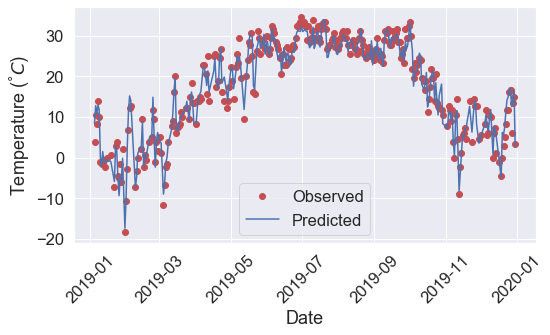

In [8]:
# Plot 
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_dates, test_verification_tmax, 'ro', label = 'Observed')
ax.plot(test_dates, lr_predictions_tmax, 'b-', label = 'Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature ($^\degree C$)')
plt.xticks(rotation = 45)
plt.legend()
plt.tight_layout()
plt.show()

### Minimum Temperature

In [9]:
# Training
train_verification_tmin = np.array(features.query('year < 2019')['Min Hourly Temp (C)'])
test_verification_tmin = np.array(features.query('year == 2019')['Min Hourly Temp (C)'])

lr_tmin_vars = ['TMAX','TMIN','tmpc','dwpc','wdir','Avg DWPDEP(C)','Avg LCLD(%)','Avg MCLD(%)','Avg HCLD(%)','Avg 925hPa DWPDEP(C)','Avg 850hPa DWPDEP(C)',
                'Max 250hPa HGT(m)','Avg 500hPa HGT(m)','Min 500hPa HGT(m)','Max 925hPa TMPC','Max 850hPa TMPC','Min 925hPa TMPC','Min 850hPa TMPC','wspd','Min 850hPa WSPD(m/s)',
                'Min 925hPa WSPD(m/s)']

lr_train_vars_tmin = predictors.query('year < 2019')[lr_tmin_vars] 
lr_test_vars_tmin = predictors.query('year == 2019')[lr_tmin_vars]

# Fit the model
lrmin = LinearRegression(fit_intercept=True)
lrmin.fit(lr_train_vars_tmin, train_verification_tmin);

In [10]:
# RMSE
lr_predictions_tmin = lrmin.predict(lr_test_vars_tmin)
print('Root Mean Square Error:', round(mean_squared_error(test_verification_tmin, lr_predictions_tmin, squared = False), 2), 'degrees C.')

Root Mean Square Error: 2.08 degrees C.


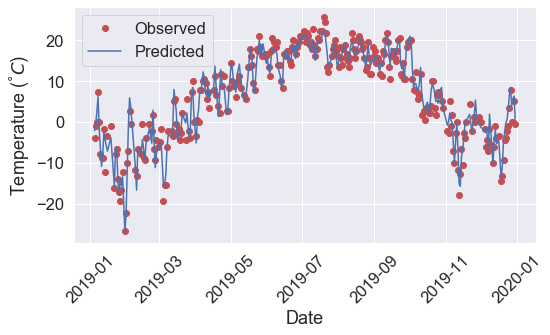

In [11]:
# Plot 
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_dates, test_verification_tmin, 'ro', label = 'Observed')
ax.plot(test_dates, lr_predictions_tmin, 'b-', label = 'Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature ($^\degree C$)')
plt.xticks(rotation = 45)
plt.legend()
plt.tight_layout()
plt.show()

### Maximum Wind Speed

In [12]:
# Training
train_verification_wind = np.array(features.query('year < 2019')['Max Wind Speed (m/s)'])
test_verification_wind = np.array(features.query('year == 2019')['Max Wind Speed (m/s)'])

lr_wind_vars = ['WMAX','tmpc','wspd','mslp','Avg DWPDEP(C)','Avg MCLD(%)','Max MCLD(%)','Avg HCLD(%)','Min HCLD(%)','Min PRES(hPa)','Max 925hPa WSPD(m/s)',
                'Avg 850hPa DWPDEP(C)','Avg 250hPa HGT(m)','Min 250hPa HGT(m)','Max 500hPa HGT(m)','Max 925hPa WSPD(m/s)','Min 925hPa WSPD(m/s)','Max 850hPa WSPD(m/s)',
                'Min 850hPa WSPD(m/s)','Max 500hPa WSPD(m/s)','Min 500hPa WSPD(m/s)','Min 925hPa TMPC','Max 850hPa TMPC','month',
                'Max 700hPa DWPDEP(C)','Max 700hPa HGT(m)','Avg 500hPa TMPC','Max 700hPa WSPD(m/s)','Avg 850hPa WSPD(m/s)'] 

lr_train_vars_wind = predictors.query('year < 2019')[lr_wind_vars] 
lr_test_vars_wind = predictors.query('year == 2019')[lr_wind_vars]

# Fit the model
lrwind = LinearRegression(fit_intercept=True)
lrwind.fit(lr_train_vars_wind, train_verification_wind);

In [13]:
# RMSE
lr_predictions_wind = lrwind.predict(lr_test_vars_wind)
print('Root Mean Square Error:', round(mean_squared_error(test_verification_wind, lr_predictions_wind, squared = False), 2), 'm/s.')

Root Mean Square Error: 1.73 m/s.


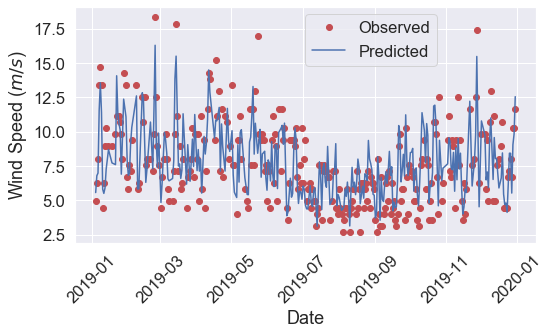

In [14]:
# Plot 
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_dates, test_verification_wind, 'ro', label = 'Observed')
ax.plot(test_dates, lr_predictions_wind, 'b-', label = 'Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Wind Speed ($m/s$)')
plt.legend(loc = [0.5, 0.75])
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

### Total Precipitation

In [15]:
# Training
train_verification_prcp = np.array(features.query('year < 2019')['Daily Precip (mm)'])
test_verification_prcp = np.array(features.query('year == 2019')['Daily Precip (mm)'])

lr_prcp_vars = ['RTOT','TMIN','skct','wdir','wspd','Min DWPDEP(C)','Avg MCLD(%)','Max MCLD(%)','Avg HCLD(%)','Max PRES(hPa)','Max 850hPa DWPDEP(C)','Min 850hPa DWPDEP(C)',
                            'Avg 500hPa HGT(m)','Max 500hPa HGT(m)','Min 500hPa HGT(m)','Max 925hPa TMPC','Min 925hPa TMPC','WMAX','Max PRES(hPa)','tmpc','mslp',
                            'Avg 700hPa DWPDEP(C)','Max 700hPa WSPD(m/s)']

lr_train_vars_prcp = predictors.query('year < 2019')[lr_prcp_vars] 
lr_test_vars_prcp = predictors.query('year == 2019')[lr_prcp_vars]

# Fit the model
lrprcp = LinearRegression(fit_intercept=True)
lrprcp.fit(lr_train_vars_prcp, train_verification_prcp);

In [16]:
# RMSE
lr_predictions_prcp = lrprcp.predict(lr_test_vars_prcp)
lr_predictions_prcp = np.array([prcp if prcp > 0.0 else 0.0 for prcp in lr_predictions_prcp]) # We get some negative precip predictions! Set to zero
print('Root Mean Square Error:', round(mean_squared_error(test_verification_prcp, lr_predictions_prcp, squared = False), 2), 'mm.')

Root Mean Square Error: 4.24 mm.


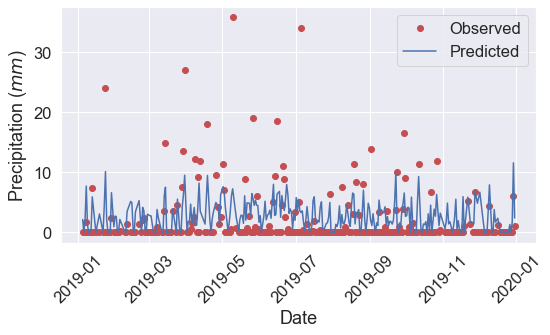

In [17]:
# Do the plot
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_dates, test_verification_prcp, 'ro', label = 'Observed')
ax.plot(test_dates, lr_predictions_prcp, 'b-', label = 'Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation ($mm$)')
plt.legend(loc = 'upper right')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

## Random Forest

### Maxmimum Temperature

In [18]:
# Training
rf_tmax_vars  = ['TMAX','TMIN','tmpc','dwpc','WMAX','day','Avg DWPDEP(C)','Max DWPDEP(C)','Avg LCLD(%)','Avg HCLD(%)','Avg PRES(hPa)','Avg 850hPa DWPDEP(C)','Max 850hPa TMPC',
                      'Min 925hPa TMPC','Max 925hPa TMPC','Min 250hPa WSPD(m/s)','Min 850hPa WSPD(m/s)']

rf_train_vars_tmax = predictors.query('year < 2019')[rf_tmax_vars] 
rf_test_vars_tmax = predictors.query('year == 2019')[rf_tmax_vars]

# Fit the model. The hyper-parameters were determined prior using RandomizedSearchCV
rfmax = RandomForestRegressor(n_estimators = 1600, random_state = 42, max_depth = 80, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 3, bootstrap = True)
rfmax.fit(rf_train_vars_tmax, train_verification_tmax);

In [19]:
# RMSE
rf_predictions_tmax = rfmax.predict(rf_test_vars_tmax)
print('Root Mean Square Error:', round(mean_squared_error(test_verification_tmax, rf_predictions_tmax, squared = False), 2), 'degrees C.')

Root Mean Square Error: 1.92 degrees C.


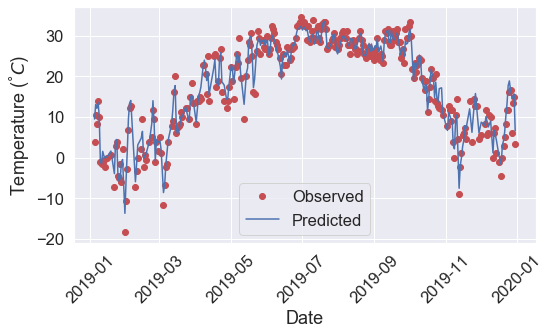

In [20]:
# Plot 
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_dates, test_verification_tmax, 'ro', label = 'Observed')
ax.plot(test_dates, rf_predictions_tmax, 'b-', label = 'Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature ($^\degree C$)')
plt.xticks(rotation = 45)
plt.legend()
plt.tight_layout()
plt.show()

### Minimum Temperature

In [21]:
# Training
rf_tmin_vars = ['TMAX','TMIN','WMAX','RTOT','mslp','wspd','skct','tmpc','dwpc','pr1h','Avg DWPDEP(C)','Avg LCLD(%)','Max LCLD(%)','Avg MCLD(%)','Avg HCLD(%)','Max HCLD(%)',
                     'Avg PRES(hPa)','Max PRES(hPa)','Avg 850hPa DWPDEP(C)','Max 850hPa DWPDEP(C)','Avg 250hPa HGT(m)','Avg 500hPa HGT(m)','Min 850hPa TMPC','Min 925hPa TMPC',
                     'Min 250hPa WSPD(m/s)','Min 925hPa WSPD(m/s)','Max 925hPa WSPD(m/s)'] 

rf_train_vars_tmin = predictors.query('year < 2019')[rf_tmin_vars] 
rf_test_vars_tmin = predictors.query('year == 2019')[rf_tmin_vars]

# Fit the model. The hyper-parameters were determined prior using RandomizedSearchCV
rfmin = rfmin = RandomForestRegressor(n_estimators = 1600, random_state = 42, max_depth = 80, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 3, bootstrap = True)
rfmin.fit(rf_train_vars_tmin, train_verification_tmin);

In [22]:
# RMSE
rf_predictions_tmin = rfmin.predict(rf_test_vars_tmin)
print('Root Mean Square Error:', round(mean_squared_error(test_verification_tmin, rf_predictions_tmin, squared = False), 2), 'degrees C.')

Root Mean Square Error: 2.11 degrees C.


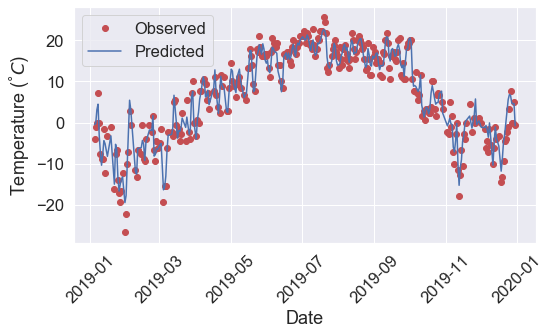

In [23]:
# Plot 
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_dates, test_verification_tmin, 'ro', label = 'Observed')
ax.plot(test_dates, rf_predictions_tmin, 'b-', label = 'Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature ($^\degree C$)')
plt.xticks(rotation = 45)
plt.legend()
plt.tight_layout()
plt.show()

### Maximum Wind Speed

In [24]:
# Training
rf_train_vars_wind = predictors.query('year < 2019').to_numpy()  # Use all available predictors
rf_test_vars_wind = predictors.query('year == 2019').to_numpy()

# Fit the model. The hyper-parameters were determined prior using RandomizedSearchCV
rfwind = RandomForestRegressor(n_estimators = 1600, random_state = 42, max_depth = 80, max_features = 'auto', min_samples_leaf = 1, min_samples_split = 3, bootstrap = True)
rfwind.fit(rf_train_vars_wind, train_verification_wind);

In [25]:
# RMSE
rf_predictions_wind = rfwind.predict(rf_test_vars_wind)
print('Root Mean Square Error:', round(mean_squared_error(test_verification_wind, rf_predictions_wind, squared = False), 2), 'm/s.')

Root Mean Square Error: 1.69 m/s.


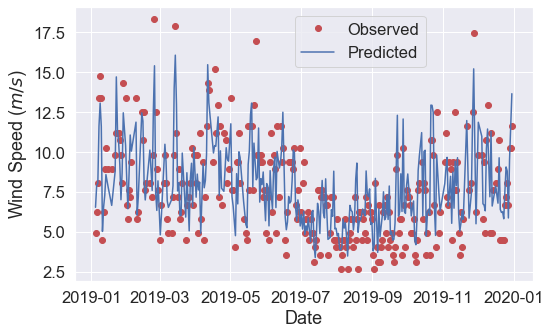

In [26]:
# Do the plot
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_dates, test_verification_wind, 'ro', label = 'Observed')
ax.plot(test_dates, rf_predictions_wind, 'b-', label = 'Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Wind Speed ($m/s$)')
plt.legend(loc = [0.48, 0.78])
plt.tight_layout()
plt.show()

### Total Precipitation

In [27]:
# Training
rf_prcp_vars = ['RTOT','TMAX','TMIN','WMAX','tmpc','mslp','skct','day','Min MCLD(%)','Max MCLD(%)','Max HCLD(%)','Avg PRES(hPa)','Min 850hPa DWPDEP(C)','Max 850hPa DWPDEP(C)',
                            'Avg 500hPa HGT(m)','Max 500hPa WSPD(m/s)','Max 925hPa WSPD(m/s)','Avg 850hPa WSPD(m/s)','Avg 500hPa WSPD(m/s)','Avg 250hPa DWPDEP(C)',
                            'Avg 500hPa DWPDEP(C)','Min 500hPa DWPDEP(C)','Avg 700hPa DWPDEP(C)','Min 700hPa DWPDEP(C)','Avg 850hPa DWPDEP(C)']

rf_train_vars_prcp = predictors.query('year < 2019')[rf_prcp_vars] 
rf_test_vars_prcp = predictors.query('year == 2019')[rf_prcp_vars]

# Fit the model. The hyper-parameters were determined prior using RandomizedSearchCV
rfprcp = RandomForestRegressor(n_estimators = 1600, random_state = 42, max_depth = 80, max_features = 'sqrt', min_samples_leaf = 8, min_samples_split = 3, bootstrap = True)
rfprcp.fit(rf_train_vars_prcp, train_verification_prcp);

In [31]:
# RMSE
rf_predictions_prcp = rfprcp.predict(rf_test_vars_prcp)
print('Root Mean Square Error:', round(mean_squared_error(test_verification_prcp, rf_predictions_prcp, squared = False), 2), 'mm.')

Root Mean Square Error: 4.18 mm.


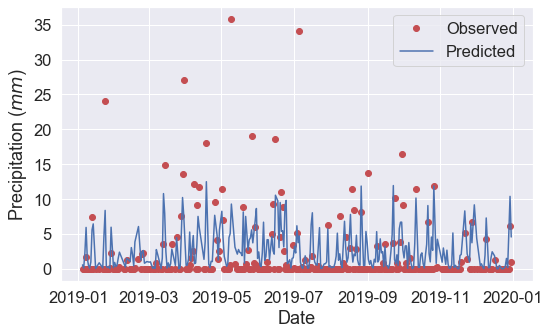

In [29]:
# Do the plot
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_dates, test_verification_prcp, 'ro', label = 'Observed')
ax.plot(test_dates, rf_predictions_prcp, 'b-', label = 'Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation ($mm$)')
plt.legend(loc = 'upper right')
plt.tight_layout()
plt.show()